
# Imports


In [ ]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pandas as pd
from google.colab import drive
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Introduction to Dynamic Time Warping

Let us use Dynamic Time Warping for kNN STFL. First, we will go into detail of what DTW is in the first place. The algorithm is as follow:


- Inputs: $x_{1:N}$ and $y_{1:M}$
- Cost matrix: $\mathbf{D} \in \mathbb{R}^{(N+1) \times (M+1)}$
   - Initialization:
    - For $i = 1$ to $N$: $D_{i,0} = \infty$
    - For $j = 1$ to $M: D_{0,j} = \infty$

- Calculate cost matrix:
  - For $i = 1$ to $N$:
    - For $j = 1$ to $M$:

      $$
      \begin{cases}
          D_{i-1,j-1} & \text{(match)} \\
          D_{i-1,j}   & \text{(insertion)} \\
          D_{i,j-1}   & \text{(deletion)}
      \end{cases}
      $$



- Get alignment: Trace back from $D_{N,M}$ to $D_{0,0}$


Consider the two sequences below to see how it plays out. The sequences are $x_{1:6}$ = $[0,0,1, 0, 2,0]$ and $y_{1:7}$ = $[0,0,0.5, 2, 1,0]$. Here N = 6 and M = 7


Mounted at /content/drive


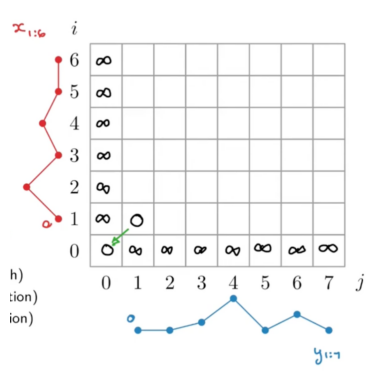

In [ ]:

drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/dynamic_warping.png"

image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV loads in BGR)

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


For each of the row, we would consider the distance of $x_i$ from all the rest of $y_i$. We will do this to fill all the rows.

| $i \backslash j$ | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   |
|-----------------|-----|-----|-----|-----|-----|-----|-----|-----|
| **0**          | 0   | ∞   | ∞   | ∞   | ∞   | ∞   | ∞   | ∞   |
| **1**          | ∞   | 0   | 0   | 0.5 | 2.5 | 2.5 | 3.5 | 3.5 |
| **2**          | ∞   | 2   | 2   | 1.5 | 0.5 | 2.5 | 3.5 | 5.5 |
| **3**          | ∞   | 2   | 2   | 2   | 2.5 | 0.5 | 1.5 | 1.5 |
| **4**          | ∞   | 3   | 3   | 2.5 | 3   | 1.5 | 0.5 | 1.5 |
| **5**          | ∞   | 3   | 3   | 3   | 4.5 | 1.5 | 1.5 | 0.5 |
| **6**          | ∞   | 3   | 3   | 3.5 | 5   | 1.5 | 2.5 | 0.5 |

Finally, we backtrack from $D_{6,7}$ to $D_{0,0}$ by moving to the smallest neighbor. For our case, the optimal warping path is:

$$
(6,7) → (5, 7) → (4,6) → (3,5) → (2,4) → (3,1) → (1,2) → (1, 1)
$$


### Sample Illustration of DTC for time series (taken from [here](https://medium.com/@markstent/dynamic-time-warping-a8c5027defb6))

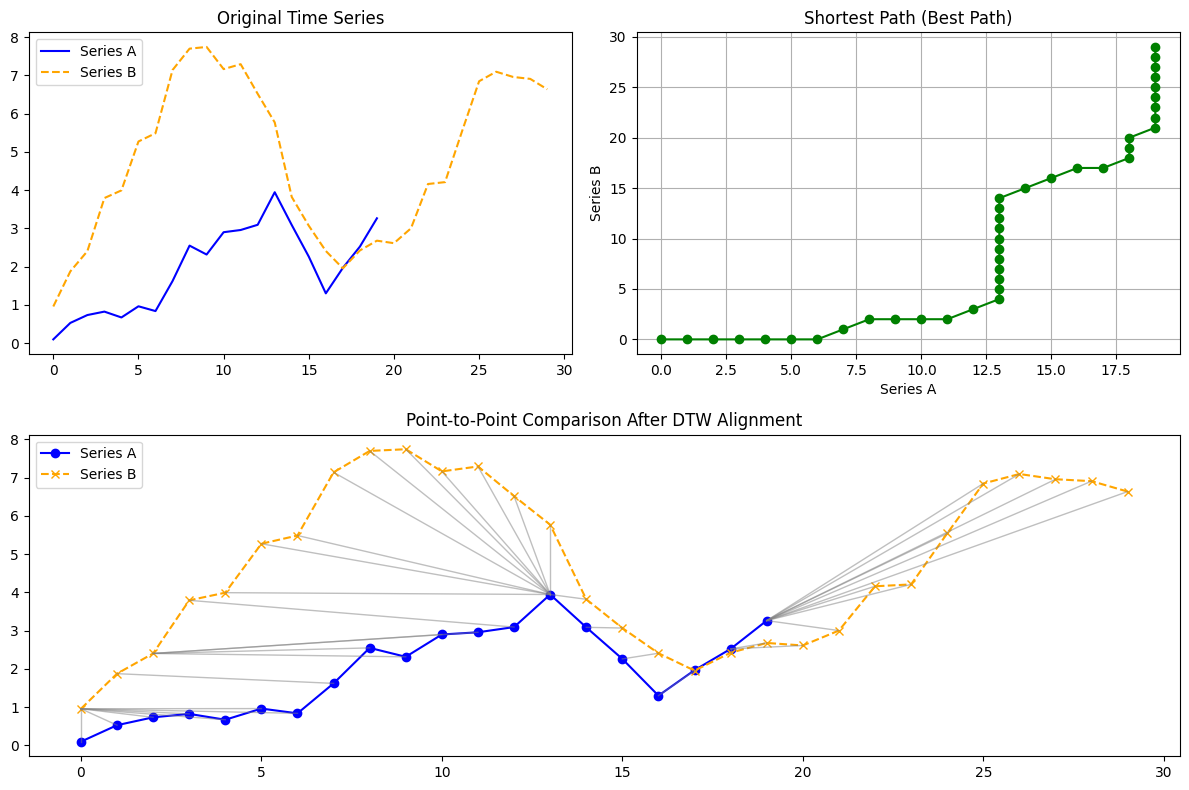

In [ ]:
np.random.seed(0)
time_series_a = np.cumsum(np.random.rand(20) * 2 - 1)
time_series_b = np.cumsum(np.random.rand(30) * 2 - 1 + np.sin(np.linspace(0, 3 * np.pi, 30)))

distance, paths = dtw.warping_paths(time_series_a, time_series_b, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

## Alignment with lagged features

Let us see how DTW works with lagged features

In [ ]:
train_path = "/content/drive/My Drive/Datasets/Panama_Dataset/train_dataframes.xlsx"
test_path = "/content/drive/My Drive/Datasets/Panama_Dataset/test_dataframes.xlsx"
train_dict = pd.read_excel(open(train_path, 'rb'), sheet_name=None, index_col=0)
test_dict = pd.read_excel(open(test_path, 'rb'), sheet_name=None, index_col=0)

In [ ]:
keys = list(train_dict.keys())
train = train_dict[keys[0]]
test = test_dict[keys[0]]

In [ ]:

lag_features = ['week_X-2']
start_date = '2019-01-01'
end_date = '2019-01-19'

x_lag_train = train.loc[start_date:end_date, lag_features].values.flatten()  # Converts to (N,)
x_lag_test = test[lag_features].values.flatten()    # Converts to (36720,)

print(x_lag_test.shape)  # Expected output: (36720,)


(168,)


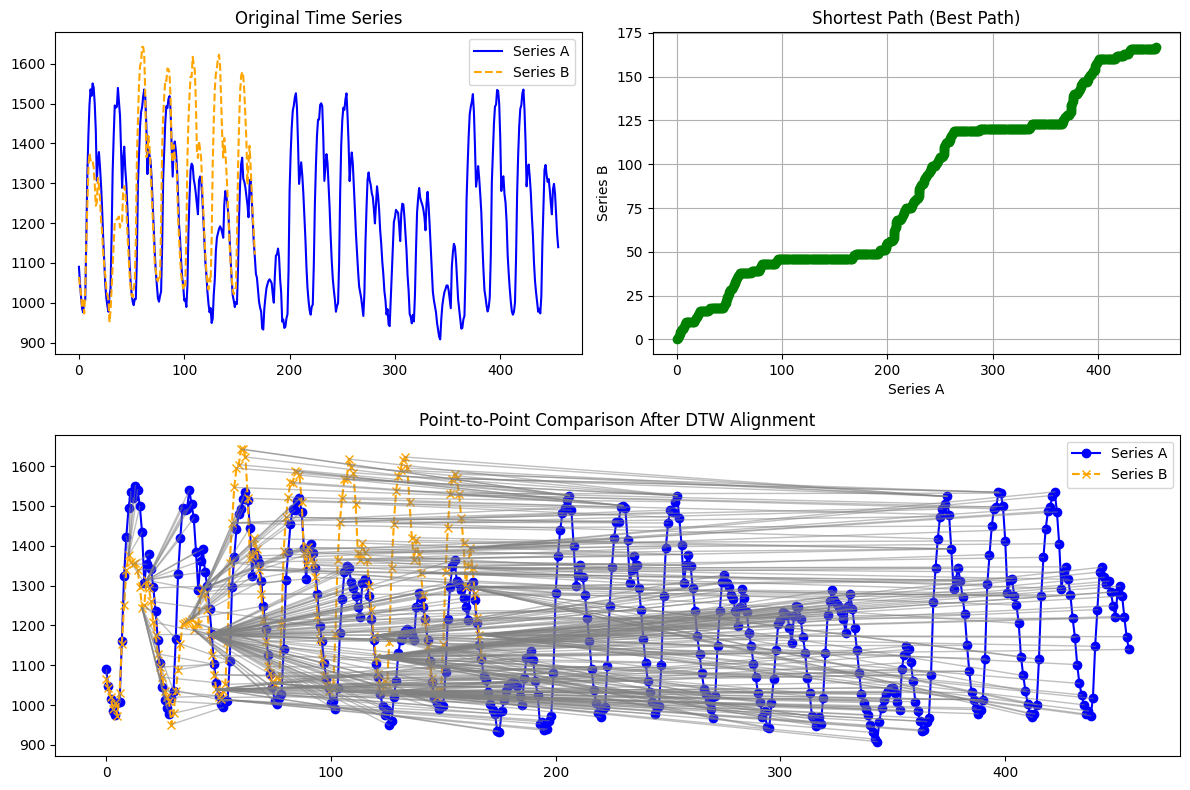

In [ ]:
distance, paths = dtw.warping_paths(x_lag_train, x_lag_test)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

plt.figure(figsize=(12, 8))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(x_lag_train, label='Series A', color='blue')
ax1.plot(x_lag_test, label='Series B', linestyle='--', color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(x_lag_train, label='Series A', color='blue', marker='o')
ax3.plot(x_lag_test, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [x_lag_train[a], x_lag_test[b]], color='grey', linestyle='-', linewidth=1, alpha=0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

# Running kNN with DTW for STLF



In [ ]:
selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
train = pd.DataFrame(train, columns=train.columns)[selected_features]
test = pd.DataFrame(test, columns=test.columns)[selected_features]

current_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc']
lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
combined_features = current_features + lag_features
y_feature = ['DEMAND']

x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]

x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]

x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]

y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
y_test = pd.DataFrame(test, columns=test.columns)[y_feature]

In [ ]:
scaler = MinMaxScaler()

x_current_train_scaled = scaler.fit_transform(x_current_train)
x_current_test_scaled = scaler.transform(x_current_test)

x_lag_train_scaled = scaler.fit_transform(x_lag_train)
x_lag_test_scaled = scaler.transform(x_lag_test)

x_combined_train_scaled = scaler.fit_transform(x_combined_train)
x_combined_test_scaled = scaler.transform(x_combined_test)

x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

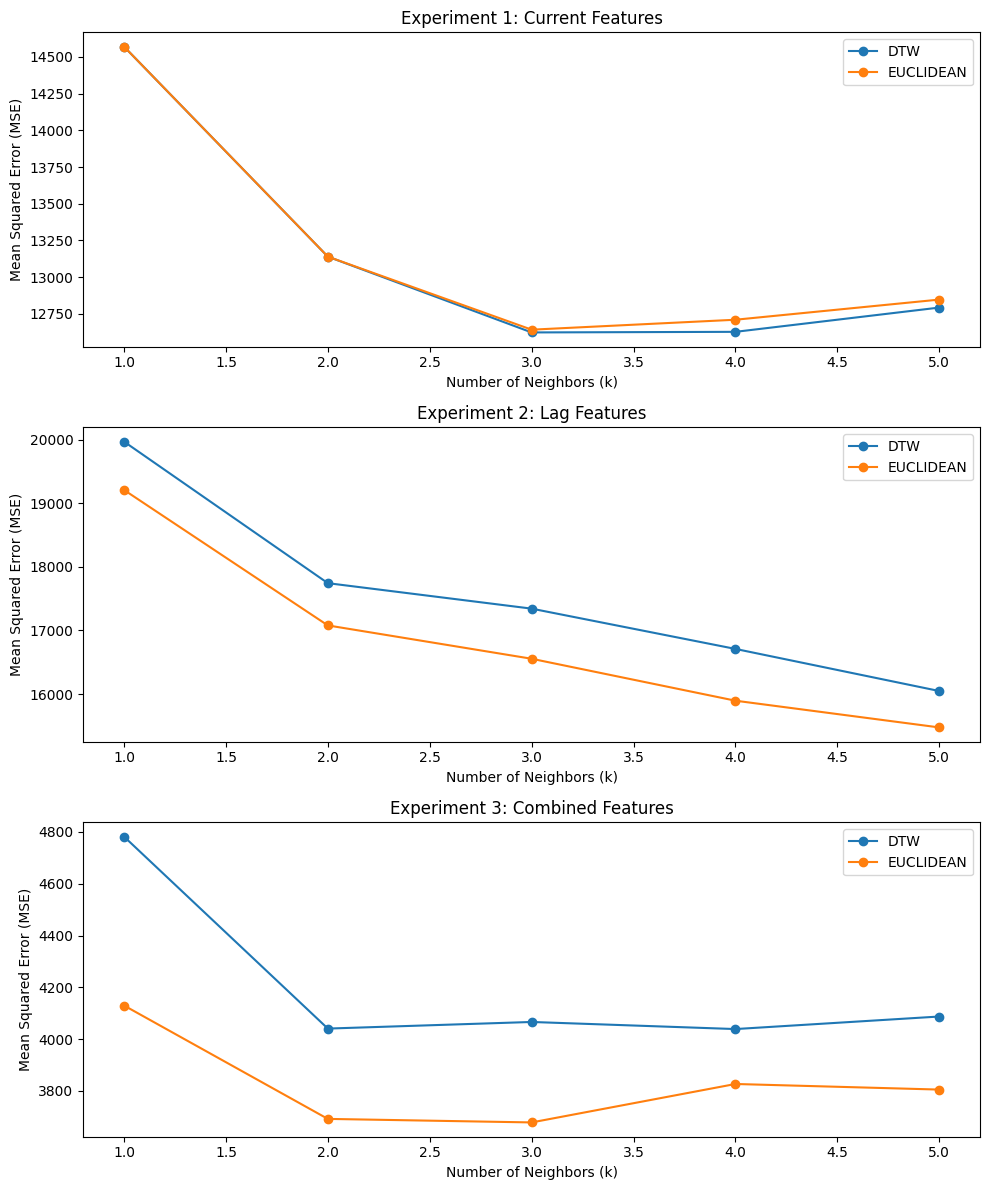

Best k (Current Features, DTW): 3
Best k (Lag Features, DTW): 5
Best k (Combined Features, DTW): 4


In [ ]:

def dtw_distance(x, y):
    return dtw.distance(x, y)

def run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric='dtw'):
    mse_values = []

    for k in k_values:
        if metric == 'dtw':
            knn = KNeighborsRegressor(n_neighbors=k, metric=dtw_distance)
        else:
            knn = KNeighborsRegressor(n_neighbors=k, metric=metric)

        knn.fit(x_train, y_train)
        predicted_labels = knn.predict(x_test)
        mse = mean_squared_error(y_test, predicted_labels)
        mse_values.append(mse)

    return mse_values

def run_knn_experiment(k_values, x_train, y_train, x_test, y_test, metric='dtw'):
    mse_values = run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric=metric)

    min_mse = min(mse_values)
    best_k = k_values[mse_values.index(min_mse)]

    plt.plot(k_values, mse_values, marker='o', label=f'{metric.upper()}')

    return min_mse, best_k

k_values = list(range(1, 6))

plt.figure(figsize=(10, 12))

# --- Experiment 1: Current Features ---
plt.subplot(3, 1, 1)
plt.title('Experiment 1: Current Features')
min_mse_current_dtw, best_k_current_dtw = run_knn_experiment(
    k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='dtw'
)
min_mse_current_euclidean, best_k_current_euclidean = run_knn_experiment(
    k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# --- Experiment 2: Lag Features ---
plt.subplot(3, 1, 2)
plt.title('Experiment 2: Lag Features')
min_mse_lag_dtw, best_k_lag_dtw = run_knn_experiment(
    k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='dtw'
)
min_mse_lag_euclidean, best_k_lag_euclidean = run_knn_experiment(
    k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# --- Experiment 3: Combined Features ---
plt.subplot(3, 1, 3)
plt.title('Experiment 3: Combined Features')
min_mse_combined_dtw, best_k_combined_dtw = run_knn_experiment(
    k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='dtw'
)
min_mse_combined_euclidean, best_k_combined_euclidean = run_knn_experiment(
    k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

plt.tight_layout()
plt.show()

# Print best k values for DTW
print(f"Best k (Current Features, DTW): {best_k_current_dtw}")
print(f"Best k (Lag Features, DTW): {best_k_lag_dtw}")
print(f"Best k (Combined Features, DTW): {best_k_combined_dtw}")

In [ ]:

def train_and_predict_knn(x_train, y_train, x_test, k, metric='manhattan'):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(x_train, y_train.values.ravel())
    predicted_labels = knn.predict(x_test)
    return predicted_labels


# Experiment 1: Current
predicted_labels_current_euclidean = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k_current_dtw, dtw_distance)

# Experiment 2: Lag
predicted_labels_lag_manhattan = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k_lag_dtw, dtw_distance)

# Experiment 3: Combined
predicted_labels_combined_manhattan = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k_combined_dtw, dtw_distance)

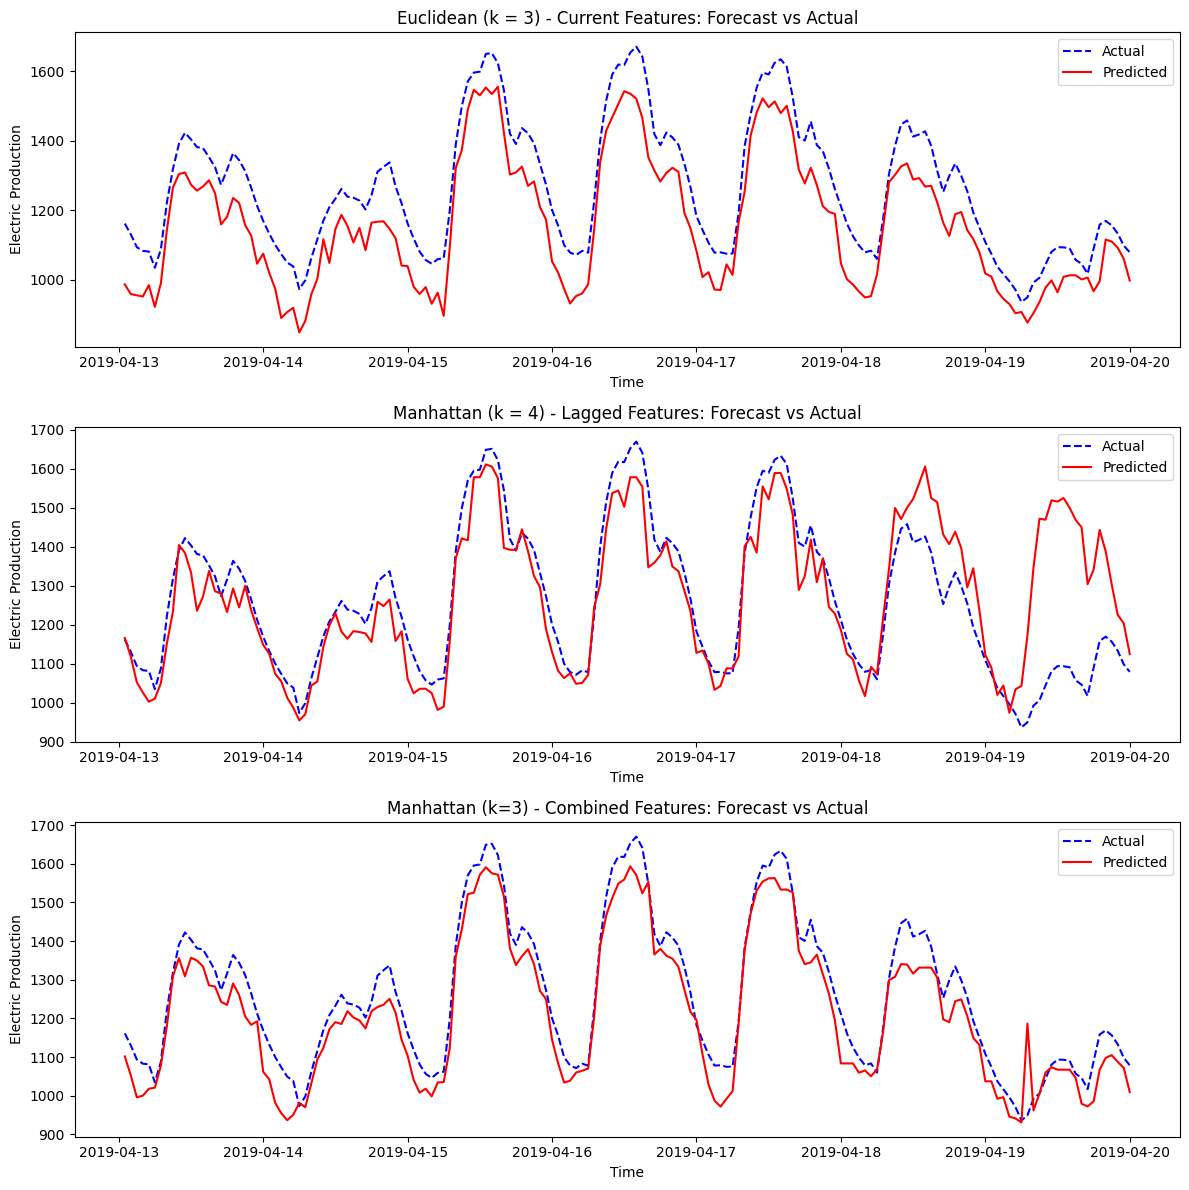

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_current_euclidean, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Euclidean (k = 3) - Current Features: Forecast vs Actual')

plt.subplot(3, 1, 2)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_lag_manhattan, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhattan (k = 4) - Lagged Features: Forecast vs Actual')

plt.subplot(3, 1, 3)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_combined_manhattan, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhattan (k=3) - Combined Features: Forecast vs Actual')

plt.tight_layout()
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse


def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

In [ ]:
predicted_df_cur = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_current_euclidean}, index=y_test.index)
predicted_df_lag = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_lag_manhattan}, index=y_test.index)
predicted_df_comb = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_combined_manhattan}, index=y_test.index)

mape_cur = mean_absolute_percentage_error(y_test, predicted_df_cur)
rmse_cur = root_mean_squared_error(y_test, predicted_df_cur)
plape_cur = peak_load_absolute_percentage_error(y_test, predicted_df_cur)
vlape_cur = value_load_absolute_percentage_error(y_test, predicted_df_cur)
eape_cur = energy_absolute_percentage_error(y_test, predicted_df_cur)


mape_lag = mean_absolute_percentage_error(y_test, predicted_df_lag)
rmse_lag = root_mean_squared_error(y_test, predicted_df_lag)
plape_lag = peak_load_absolute_percentage_error(y_test, predicted_df_lag)
vlape_lag = value_load_absolute_percentage_error(y_test, predicted_df_lag)
eape_lag = energy_absolute_percentage_error(y_test, predicted_df_lag)


mape_comb = mean_absolute_percentage_error(y_test, predicted_df_comb)
rmse_comb = root_mean_squared_error(y_test, predicted_df_comb)
plape_comb = peak_load_absolute_percentage_error(y_test, predicted_df_comb)
vlape_comb = value_load_absolute_percentage_error(y_test, predicted_df_comb)
eape_comb = energy_absolute_percentage_error(y_test, predicted_df_comb)

metrics_df = pd.DataFrame({
    "Feature Set": ["Current Features", "Lagged Features", "Combined Features"],
    "MAPE": [mape_cur, mape_lag, mape_comb],
    "RMSE": [rmse_cur, rmse_lag, rmse_comb],
    "PLAPE": [plape_cur, plape_lag, plape_comb],
    "VLAPE": [vlape_cur, vlape_lag, vlape_comb],
    "EAPE": [eape_cur, eape_lag, eape_comb]
})

display(metrics_df)


,Feature Set,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,Current Features,8.51,112.355395,6.911639,9.345021,8.402094
1,Lagged Features,6.86,126.677209,3.503406,1.925642,0.644784
2,Combined Features,4.30,63.549539,4.596262,0.544765,3.974575


Notice that DTW gives comparable results to Euclidean and Manhattan but not necessarily superior to them (for our Combined Features, the MAPE was better when Euclidean was used as a metric). Then is because in STFL slight time distortions are not  the primary challenge. Furthermore, the computational complexity of DTW is more expensive ($O(N^2)$ vs $O(N)$). This means that normal kNN with Euclidean and Manhatten distance is the way to go.
